In [1]:
## This notebook is a test environment for automatically indexing the drone data into grids and passes... 

## First, import general packages for running python analysis:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz

## Then, import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

In [2]:
## Read in the Drone_Data class, lets choose "FLY653.csv":
## We'll use the minimum necessary input parameters:
    # FLYTAG - the filename of the selected file
    # Drone_Directory - the directory location containing the file
    # site_class - the site config class, which we defined above as 'gbosite'
## The following input parameters will be left to their default setting:
    # skip_rows=range(500).tolist() - this is how many rows are skipped to omit NAN values.
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY653.csv',site_class=gbosite)

Initializing drone data via datcon_csv routine: FLY653.csv
 --> Skipping rows 1 to 499 to eliminate NAN values
 --> Attempting to load position data from RTK
 ----> RTK Data not found for this data file...
 --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
 --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
 --> generating dish and receiver line of sight coordinates.


In [14]:
## Read in the Corr_Data class, corresponding to the "FLY653.csv" file.
## We'll use the minimum necessary input parameters:
    # Data_Directory - the directory location containing the correlator files
    # Gain_Directory - the directory location containing the gain file
    # site_class - the site config class, which we defined above as 'gbosite'
## The following input parameters will be left to their default setting:
    # Data_File_Index=None - data files to use (default --> all files)
    # Load_Gains=True
    # Fix_Gains=False - should we apply a fixed gain in each channel? (only use when known from config)
    # Apply_Gains=True - if set to False, the V arrays will contain uncalibrated "raw" data
    # Gain_Params=[1.0, 24.0] - if applying a fixed gain, the gain in each channel will be: 1.0*(10**24.0)
    # fbounds=[0, -1] - what frequency bounds should we pull from the visibility matrix?
datadir='/hirax/GBO_Oct_2021/TONE_ACQ/20211022T215446Z_yale_drone/corr/20211022T215459Z/'
gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211022T215446Z_yale_drone_yale_digitalgain/'
corrtest=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite)

Initializing Correlator Class using:
 --> /hirax/GBO_Oct_2021/TONE_ACQ/20211022T215446Z_yale_drone/corr/20211022T215459Z/
 --> Arrays initialized with shape (108, 256, 1023, 16)
Assigning array values by reading in data files:
 --> Loading File: 0107/0107

In [15]:
## Since we know the data are from the same time we can combine them with the Concat_Class:
concattest=concat.CONCAT(CORRDATCLASS=corrtest,DRONEDATCLASS=dronetest)

Initializing CONCAT CLASS using:
 --> /hirax/GBO_Oct_2021/TONE_ACQ/20211022T215446Z_yale_drone/corr/20211022T215459Z/
 --> FLY653.csv
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 25685 elements
  --> drone timestamp axis contains 11138 elements


/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:107: RuntimeWarning: invalid value encountered in true_divide
  normminsubdata=minsubdata/np.nanmax(minsubdata)
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:118: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:107: RuntimeWarning: invalid value encountered in true_divide
  normminsubdata=minsubdata/np.nanmax(minsubdata)
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:118: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]


Maximum Pearson_R Correlations:
  --> t_indices = [435. 435. 414. 406.  nan 417. 413. 414. 427. 432. 438. 438. 432.  nan
 417. 405.]
  --> t_offsets = [-0.22582583 -0.22582583 -0.23423423 -0.23743744         nan -0.23303303
 -0.23463463 -0.23423423 -0.22902903 -0.22702703 -0.22462462 -0.22462462
 -0.22702703         nan -0.23303303 -0.23783784]
Selecting global time offset:
  --> global_t_offset = -0.2100310310
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:165: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  tight_layout()


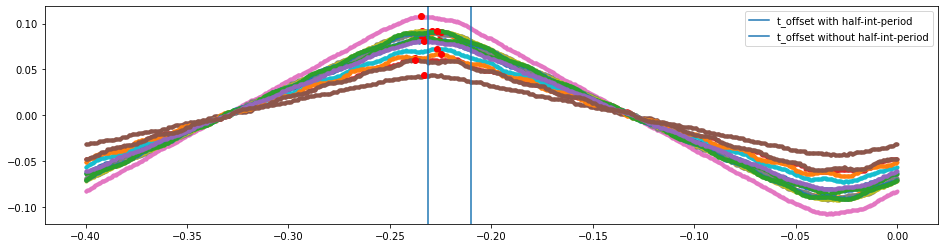

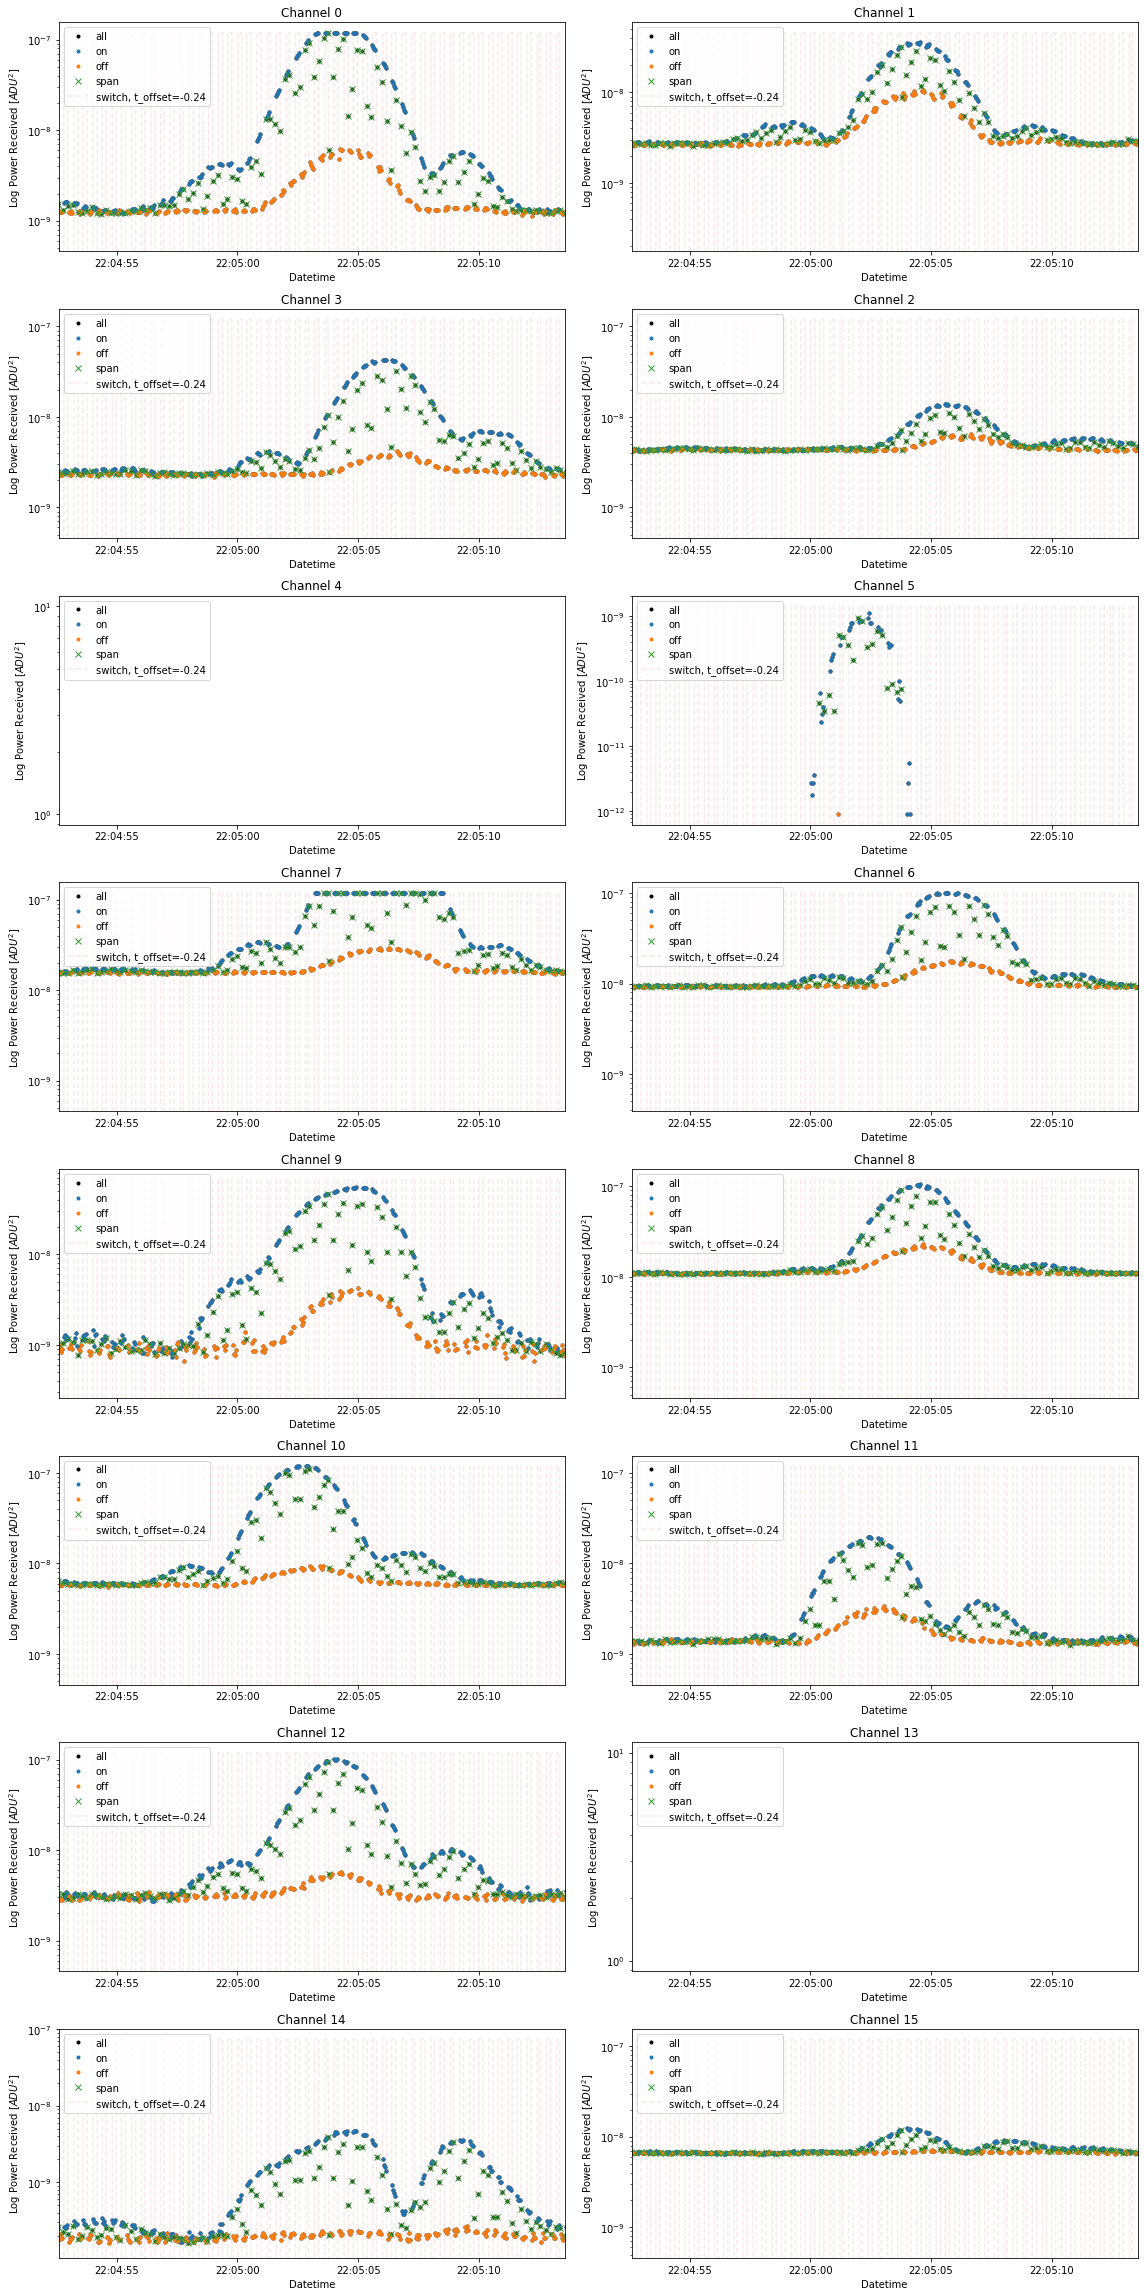

In [16]:
## Let's use the Extract_Source_Pulses and Perform_Background_Subtraction functions:
    # The Period and Dutycycle options are known beforehand, and given in microseconds.
    # The t_bounds option just determines the plot bounds, not the solving routine:
concattest.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[14200,14700])

## Let's do background subtraction: creates computed background (V_bg) and background-subtracted (V_bgsub) arrays:
    # window_size=5 - this is 1/2 the width of the 'index window' across which the background is averaged.
concattest.Perform_Background_Subtraction()

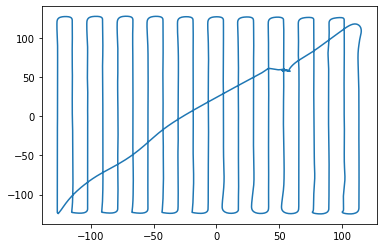

In [20]:
## Trying to find ways of isolating grid indices and then splitting the grid into passes:

plot(concattest.drone_xyz_LC_interp[:,0],concattest.drone_xyz_LC_interp[:,1])
#plot(dronetest.drone_xyz_LC_interp[:,2])

In [490]:
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

def lin_model(x,m,b):
    return m*x+b

def sin_model(x,A,w,p,B):
    return A*np.sin(x*w+p)+B

[3778, 24951]

 --> Linear model describes X coordinate data best:
       Linear Fit: X=-0.0118*t+163.9772
       Linear Residual: 1620.5527
 --> Sinusoidal model describes Y coordinate data best:
       Sinusoidal Fit: Y=-109.5102*np.sin(0.0032*t+2.9513)+0.8094
       Sinusoudal Residual: 2497.6794
       Sinusoidal fit finds 22 approximate extrema:
         [ 4416  5384  6352  7320  8288  9257 10225 11193 12161 13129 14098 15066
 16034 17002 17970 18939 19907 20875 21843 22811 23780 24748]


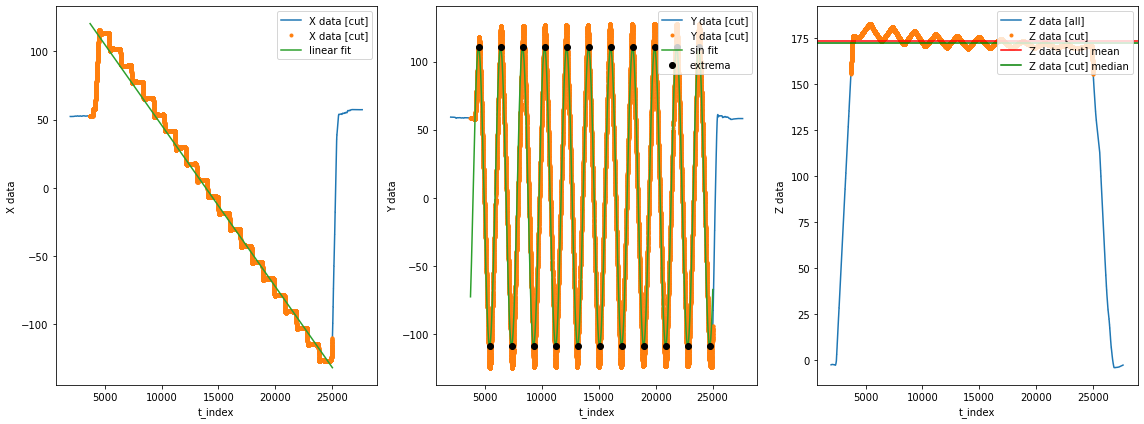

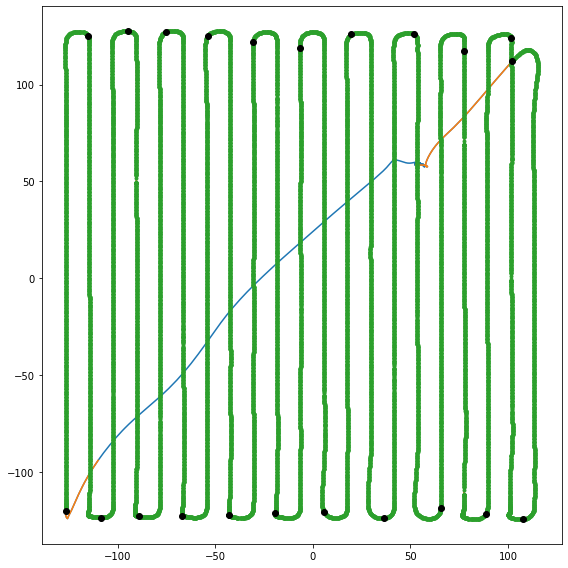

In [599]:
fig=figure(figsize=(16,6))

tt=concattest.t_index
xx=concattest.drone_xyz_LC_interp[:,0]
yy=concattest.drone_xyz_LC_interp[:,1]
zz=concattest.drone_xyz_LC_interp[:,2]
tt_min,tt_max=[np.where(zz>=0.85*np.nanmax(zz))[0][i] for i in [0,-1]]

ax1=fig.add_subplot(1,3,1)
ax1.plot(tt,xx,label="X data [cut]")
ax1.plot(tt[tt_min:tt_max],xx[tt_min:tt_max],'.',label="X data [cut]")
Lpopt,Lpcov=curve_fit(lin_model,tt[tt_min:tt_max],xx[tt_min:tt_max])
Spopt,Spcov=curve_fit(sin_model,tt[tt_min:tt_max],xx[tt_min:tt_max],p0=[150,0.0035,0,0])
LRes=np.linalg.norm(xx[tt_min:tt_max]-lin_model(tt[tt_min:tt_max],*Lpopt))
SRes=np.linalg.norm(xx[tt_min:tt_max]-sin_model(tt[tt_min:tt_max],*Spopt))
if LRes<SRes:
    print(" --> Linear model describes X coordinate data best:")
    ax1.plot(tt[tt_min:tt_max],lin_model(tt[tt_min:tt_max],*Lpopt),label="linear fit")
    print("       Linear Fit: X={:.4f}*t+{:.4f}".format(*Lpopt))
    print("       Linear Residual: {:.4f}".format(LRes))
elif LRes>SRes:
    print(" --> Sinusoidal model describes X coordinate data best:")
    ax1.plot(tt[tt_min:tt_max],sin_model(tt[tt_min:tt_max],*Spopt),label="sin fit")
    print("       Sinusoidal Fit: X={:.4f}*np.sin({:.4f}*t+{:.4f})+{:.4f}".format(*Spopt))
    print("       Sinusoudal Residual: {:.4f}".format(SRes))
    pks=argrelextrema(np.abs(sin_model(tt[tt_min:tt_max],*Spopt)),np.greater)[0]+tt_min
    ax1.plot(tt[pks],sin_model(tt,*Spopt)[pks],'ko',label='extrema')
    print("       Sinusoidal fit finds {} approximate extrema:".format(len(pks)))
    print("         {}".format(tt[pks]))

ax2=fig.add_subplot(1,3,2)
ax2.plot(tt,yy,label="Y data [cut]")
ax2.plot(tt[tt_min:tt_max],yy[tt_min:tt_max],'.',label="Y data [cut]")
Lpopt,Lpcov=curve_fit(lin_model,tt[tt_min:tt_max],yy[tt_min:tt_max])
Spopt,Spcov=curve_fit(sin_model,tt[tt_min:tt_max],yy[tt_min:tt_max],p0=[150,0.0035,0,0])
LRes=np.linalg.norm(yy[tt_min:tt_max]-lin_model(tt[tt_min:tt_max],*Lpopt))
SRes=np.linalg.norm(yy[tt_min:tt_max]-sin_model(tt[tt_min:tt_max],*Spopt))
if LRes<SRes:
    print(" --> Linear model describes Y coordinate data best:")
    ax2.plot(tt[tt_min:tt_max],lin_model(tt[tt_min:tt_max],*Lpopt),label="linear fit")
    print("       Linear Fit: X={:.4f}*t+{:.4f}".format(*Lpopt))
    print("       Linear Residual: {:.4f}".format(LRes))
elif LRes>SRes:
    print(" --> Sinusoidal model describes Y coordinate data best:")
    ax2.plot(tt[tt_min:tt_max],sin_model(tt[tt_min:tt_max],*Spopt),label="sin fit")
    print("       Sinusoidal Fit: Y={:.4f}*np.sin({:.4f}*t+{:.4f})+{:.4f}".format(*Spopt))
    print("       Sinusoudal Residual: {:.4f}".format(SRes))
    pks=argrelextrema(np.abs(sin_model(tt[tt_min:tt_max],*Spopt)),np.greater)[0]+tt_min
    ax2.plot(tt[pks],sin_model(tt,*Spopt)[pks],'ko',label='extrema')
    print("       Sinusoidal fit finds {} approximate extrema:".format(len(pks)))
    print("         {}".format(tt[pks]))
    
ax3=fig.add_subplot(1,3,3)
ax3.plot(tt,zz,label="Z data [all]")
ax3.plot(tt[tt_min:tt_max],zz[tt_min:tt_max],'.',label="Z data [cut]")
ax3.axhline(np.nanmean(zz[tt_min:tt_max]),c='r',label="Z data [cut] mean")
ax3.axhline(np.nanmedian(zz[tt_min:tt_max]),c='g',label="Z data [cut] median")

data=[xx,yy,zz]
keys=["X","Y","Z"]
for i,ax in enumerate([ax1,ax2,ax3]):
    ax.legend(loc=1)
    ax.set_ylabel("{} data".format(keys[i]))
    ax.set_xlabel("t_index")

tight_layout()


fig1=figure(figsize=(8,8))
ax0=fig1.add_subplot(1,1,1)
ax0.plot(xx,yy)
ax0.plot(xx[tt_min:tt_max],yy[tt_min:tt_max])
ax0.plot(xx[pks[0]:pks[-1]],yy[pks[0]:pks[-1]],'.')
ax0.plot(xx[pks],yy[pks],'ko')
tight_layout()

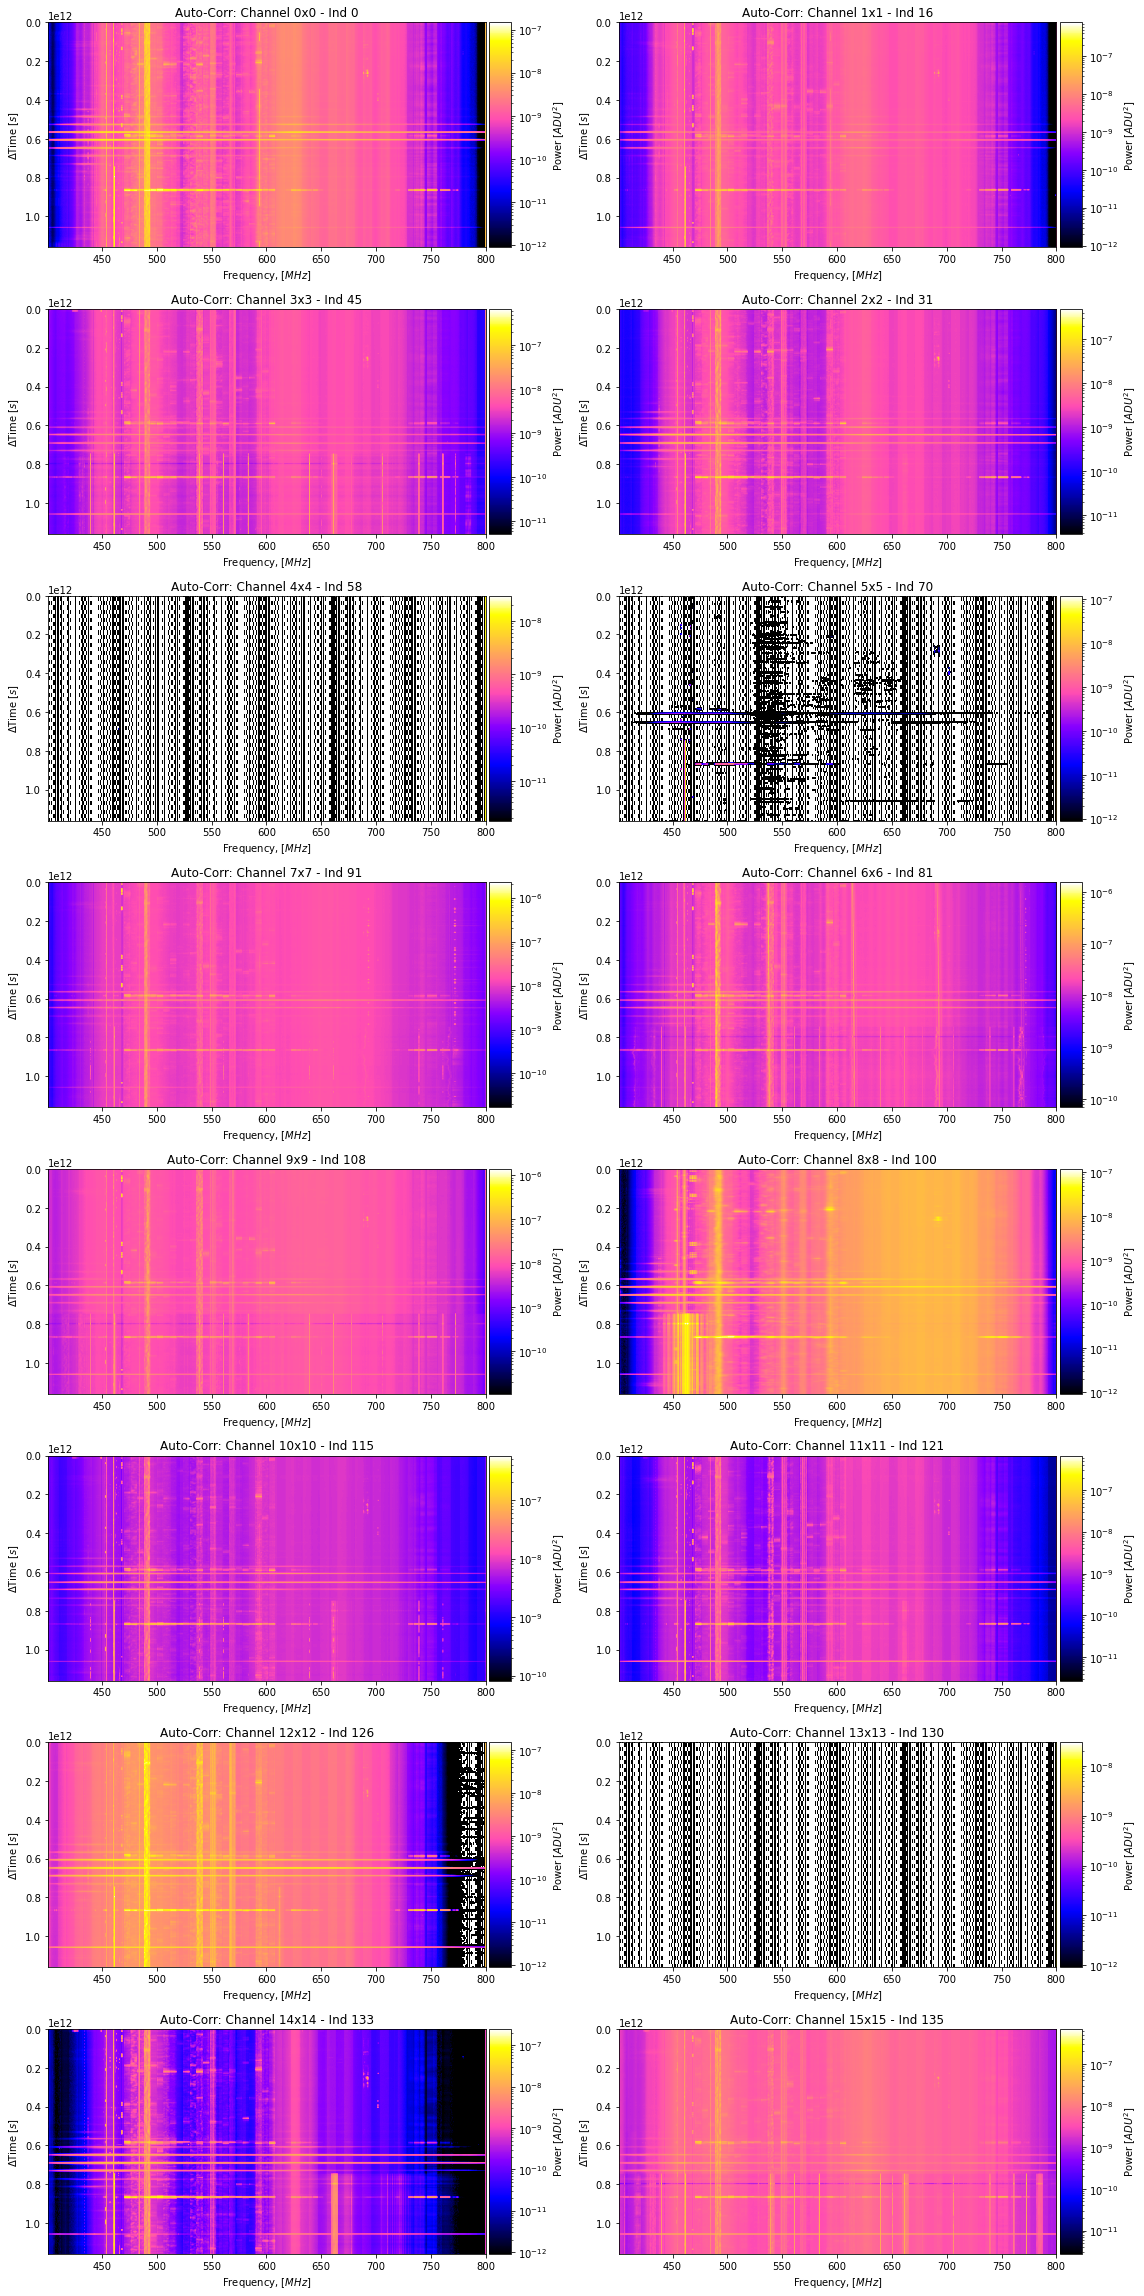

In [679]:
pu.Plot_Waterfalls(concattest)

/home/tyndall/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


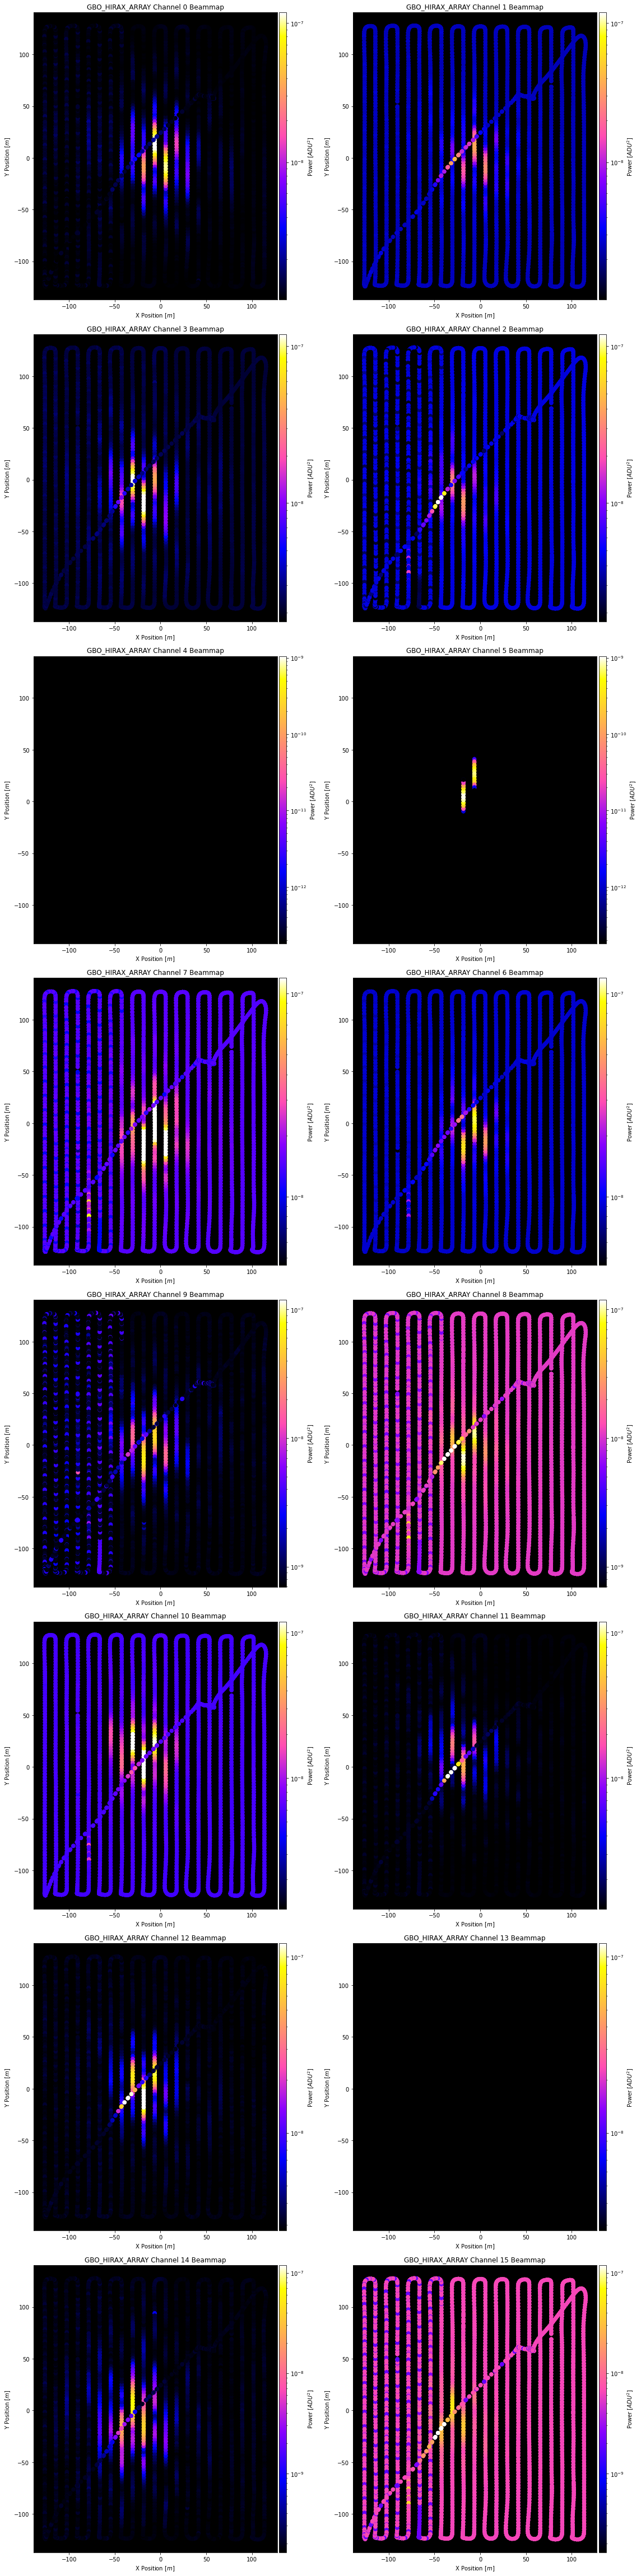

In [682]:
pu.Plot_Beammap(concattest,pulse_args='on',f_bounds=[900,905])

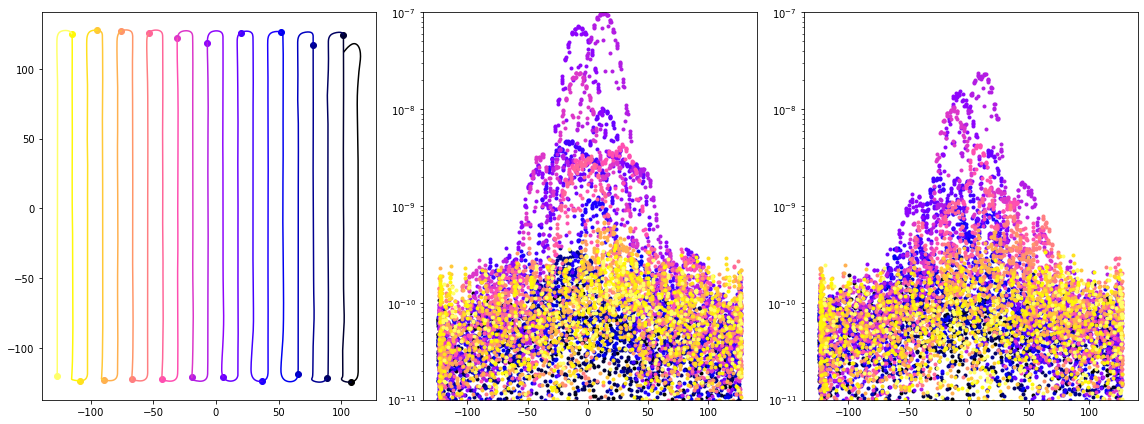

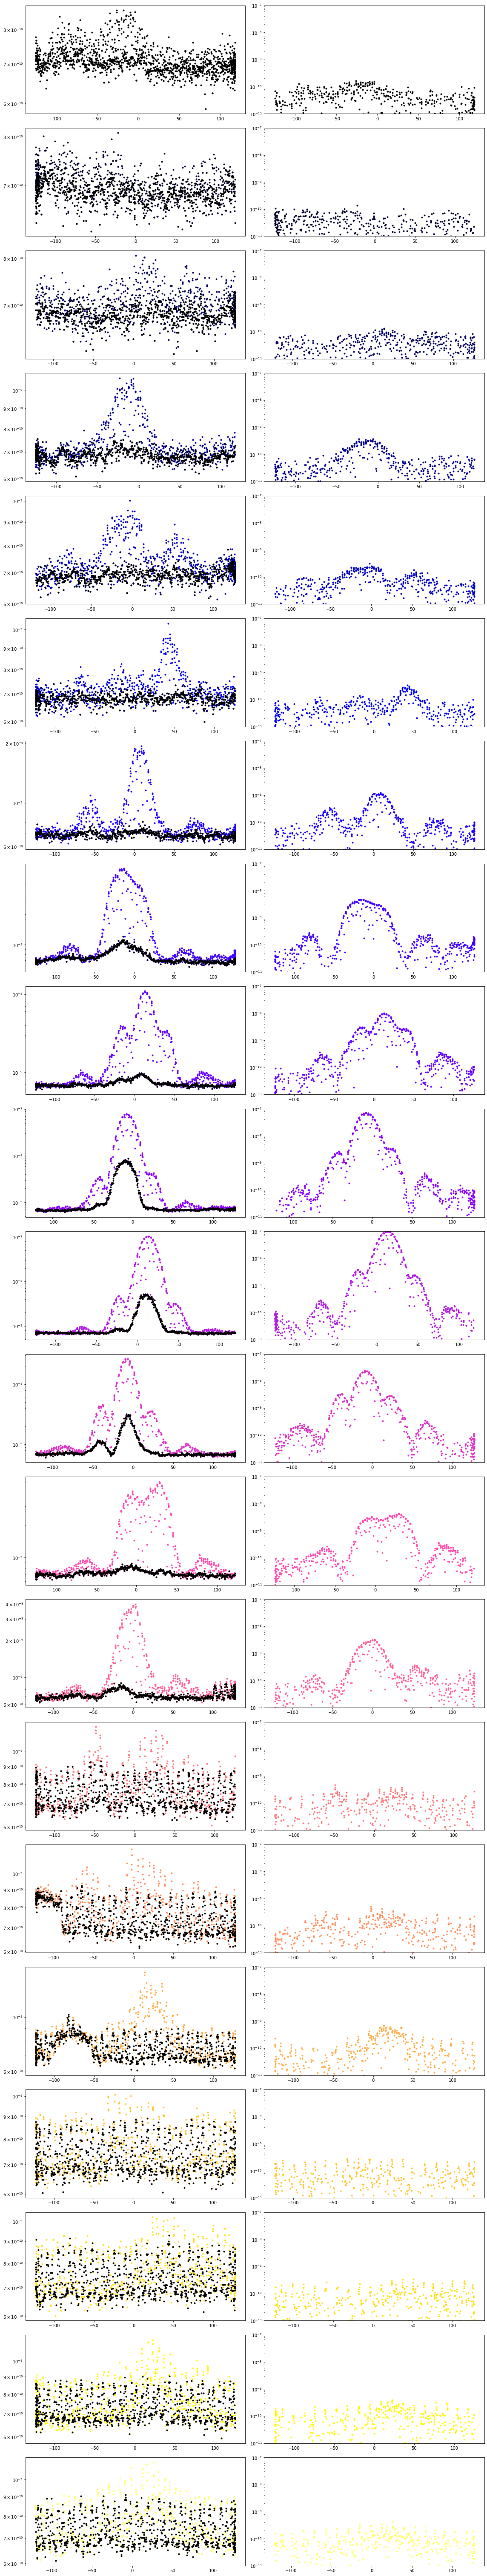

In [684]:
colorsarr=cm.gnuplot2(np.linspace(0,1,len(pks)))
find=910

fig,[ax1,ax2,ax3]=subplots(1,3,figsize=(16,6))
for j,ind in enumerate(pks[:-1]):
    tlo,thi=([pks[j],pks[j+1]])
    ax1.plot(concattest.drone_xyz_LC_interp[tlo:thi,0],concattest.drone_xyz_LC_interp[tlo:thi,1],c=colorsarr[j])
    ax1.plot(concattest.drone_xyz_LC_interp[thi,0],concattest.drone_xyz_LC_interp[thi,1],'o',c=colorsarr[j])
    ax2.semilogy(concattest.drone_xyz_LC_interp[tlo:thi,1],concattest.V_bgsub[tlo:thi,find,0],'.',c=colorsarr[j])
    ax3.semilogy(concattest.drone_xyz_LC_interp[tlo:thi,1],concattest.V_bgsub[tlo:thi,find,1],'.',c=colorsarr[j])
    ax2.set_ylim(1e-11,1e-7)
    ax3.set_ylim(1e-11,1e-7)
tight_layout()

fig2=figure(figsize=(16,len(pks)*4))
for j,ind in enumerate(pks[:-1]):
    ax1=fig2.add_subplot(len(pks),2,int(2*j)+1)
    tlo,thi=([pks[j],pks[j+1]])
    ax1.semilogy(concattest.drone_xyz_LC_interp[tlo:thi,1],concattest.V[tlo:thi,find,0],'.',c=colorsarr[j])
    ax1.semilogy(concattest.drone_xyz_LC_interp[tlo:thi,1],concattest.V_bg[tlo:thi,find,0],'k.')
    ax2=fig2.add_subplot(len(pks),2,int(2*j)+2)
    ax2.semilogy(concattest.drone_xyz_LC_interp[tlo:thi,1],concattest.V_bgsub[tlo:thi,find,0],'.',c=colorsarr[j])
    ax2.set_ylim(1e-11,1e-7)
tight_layout()

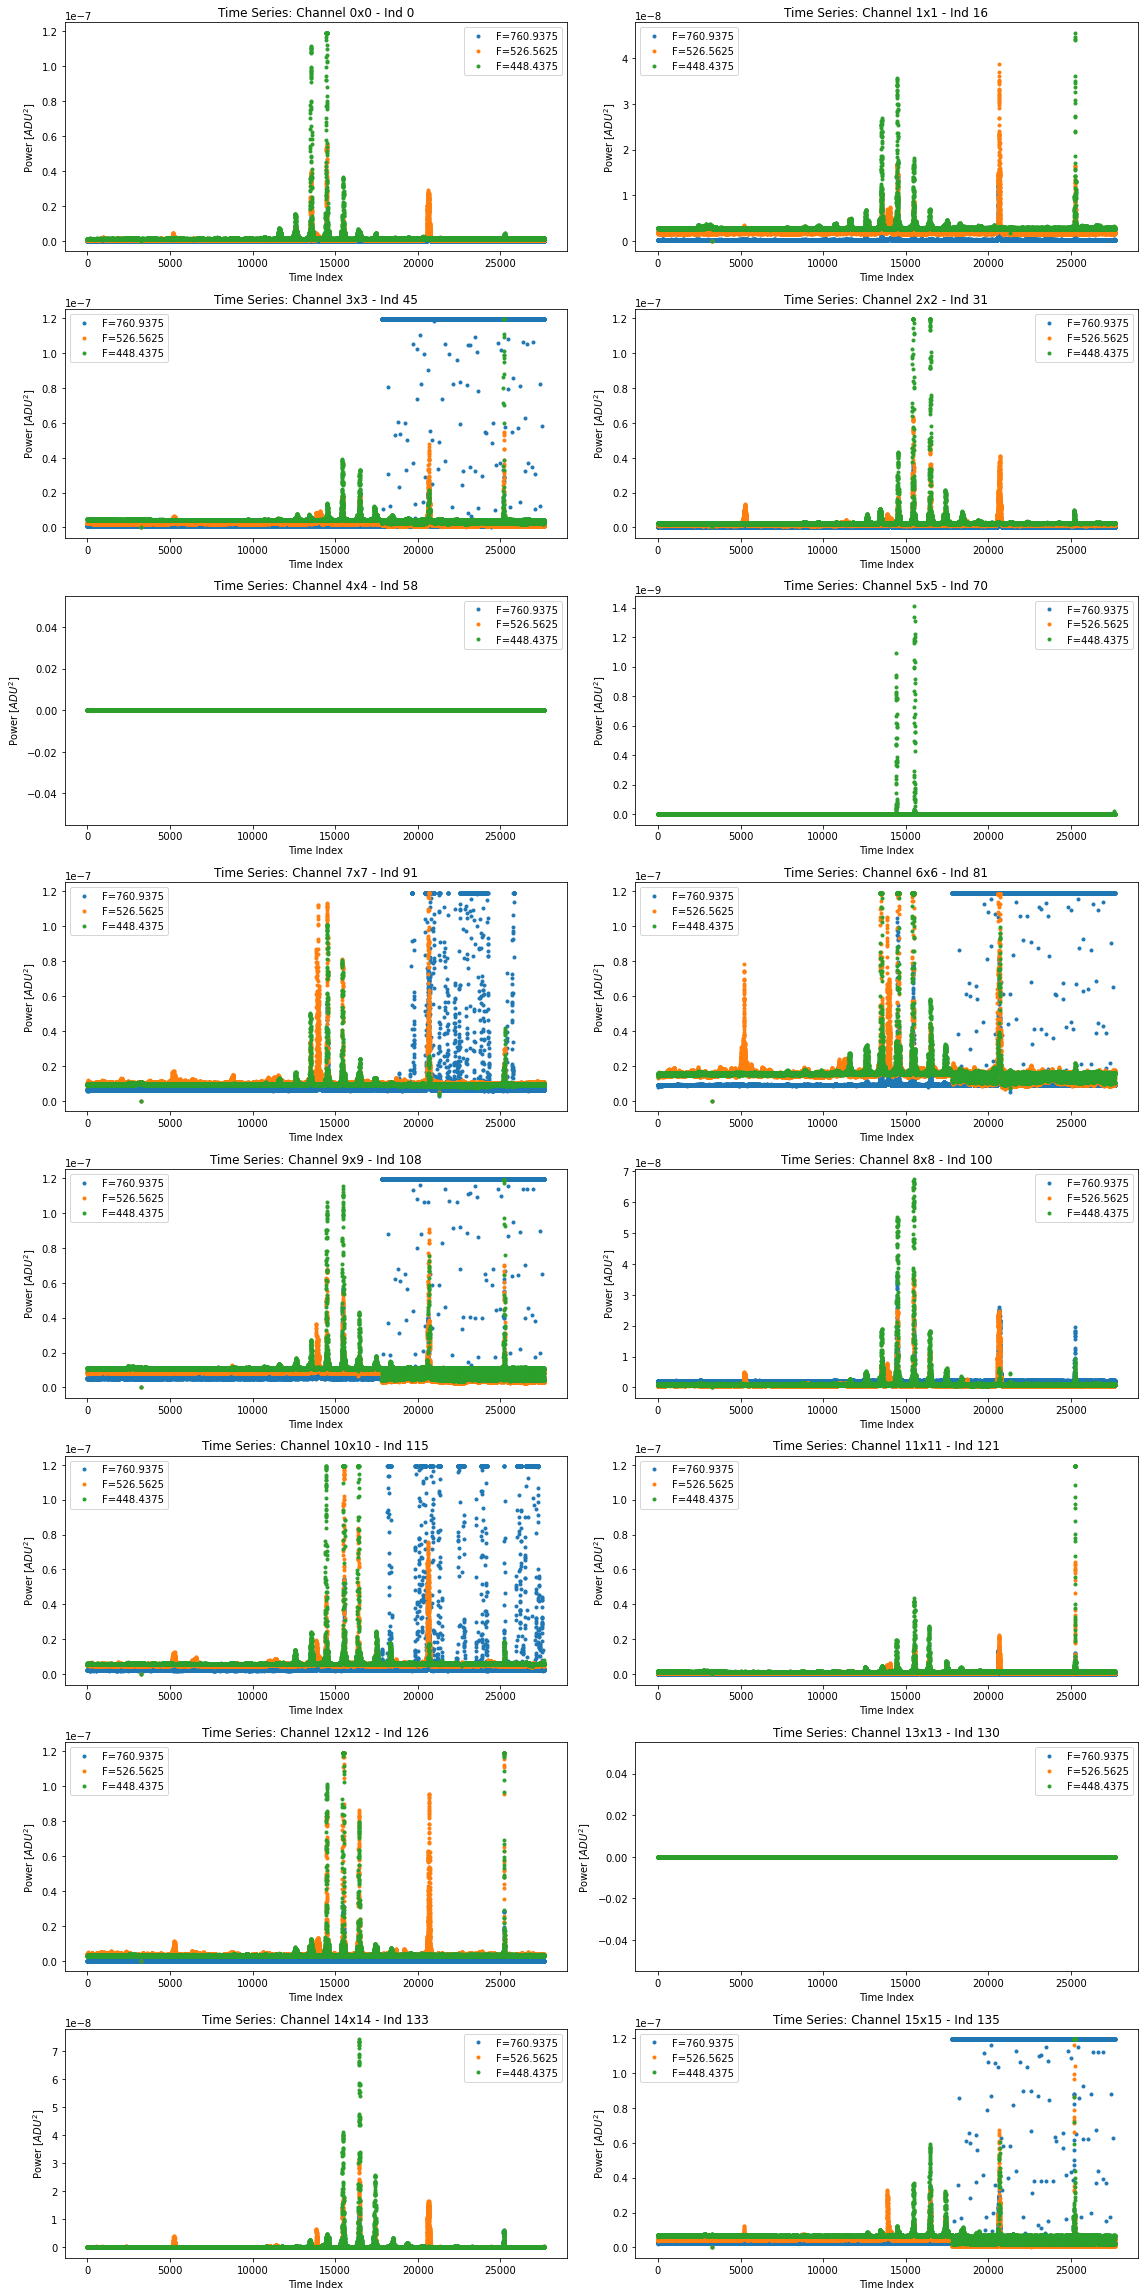

In [698]:
pu.Plot_Time_Series(concattest)#tbounds=[14000,15000])

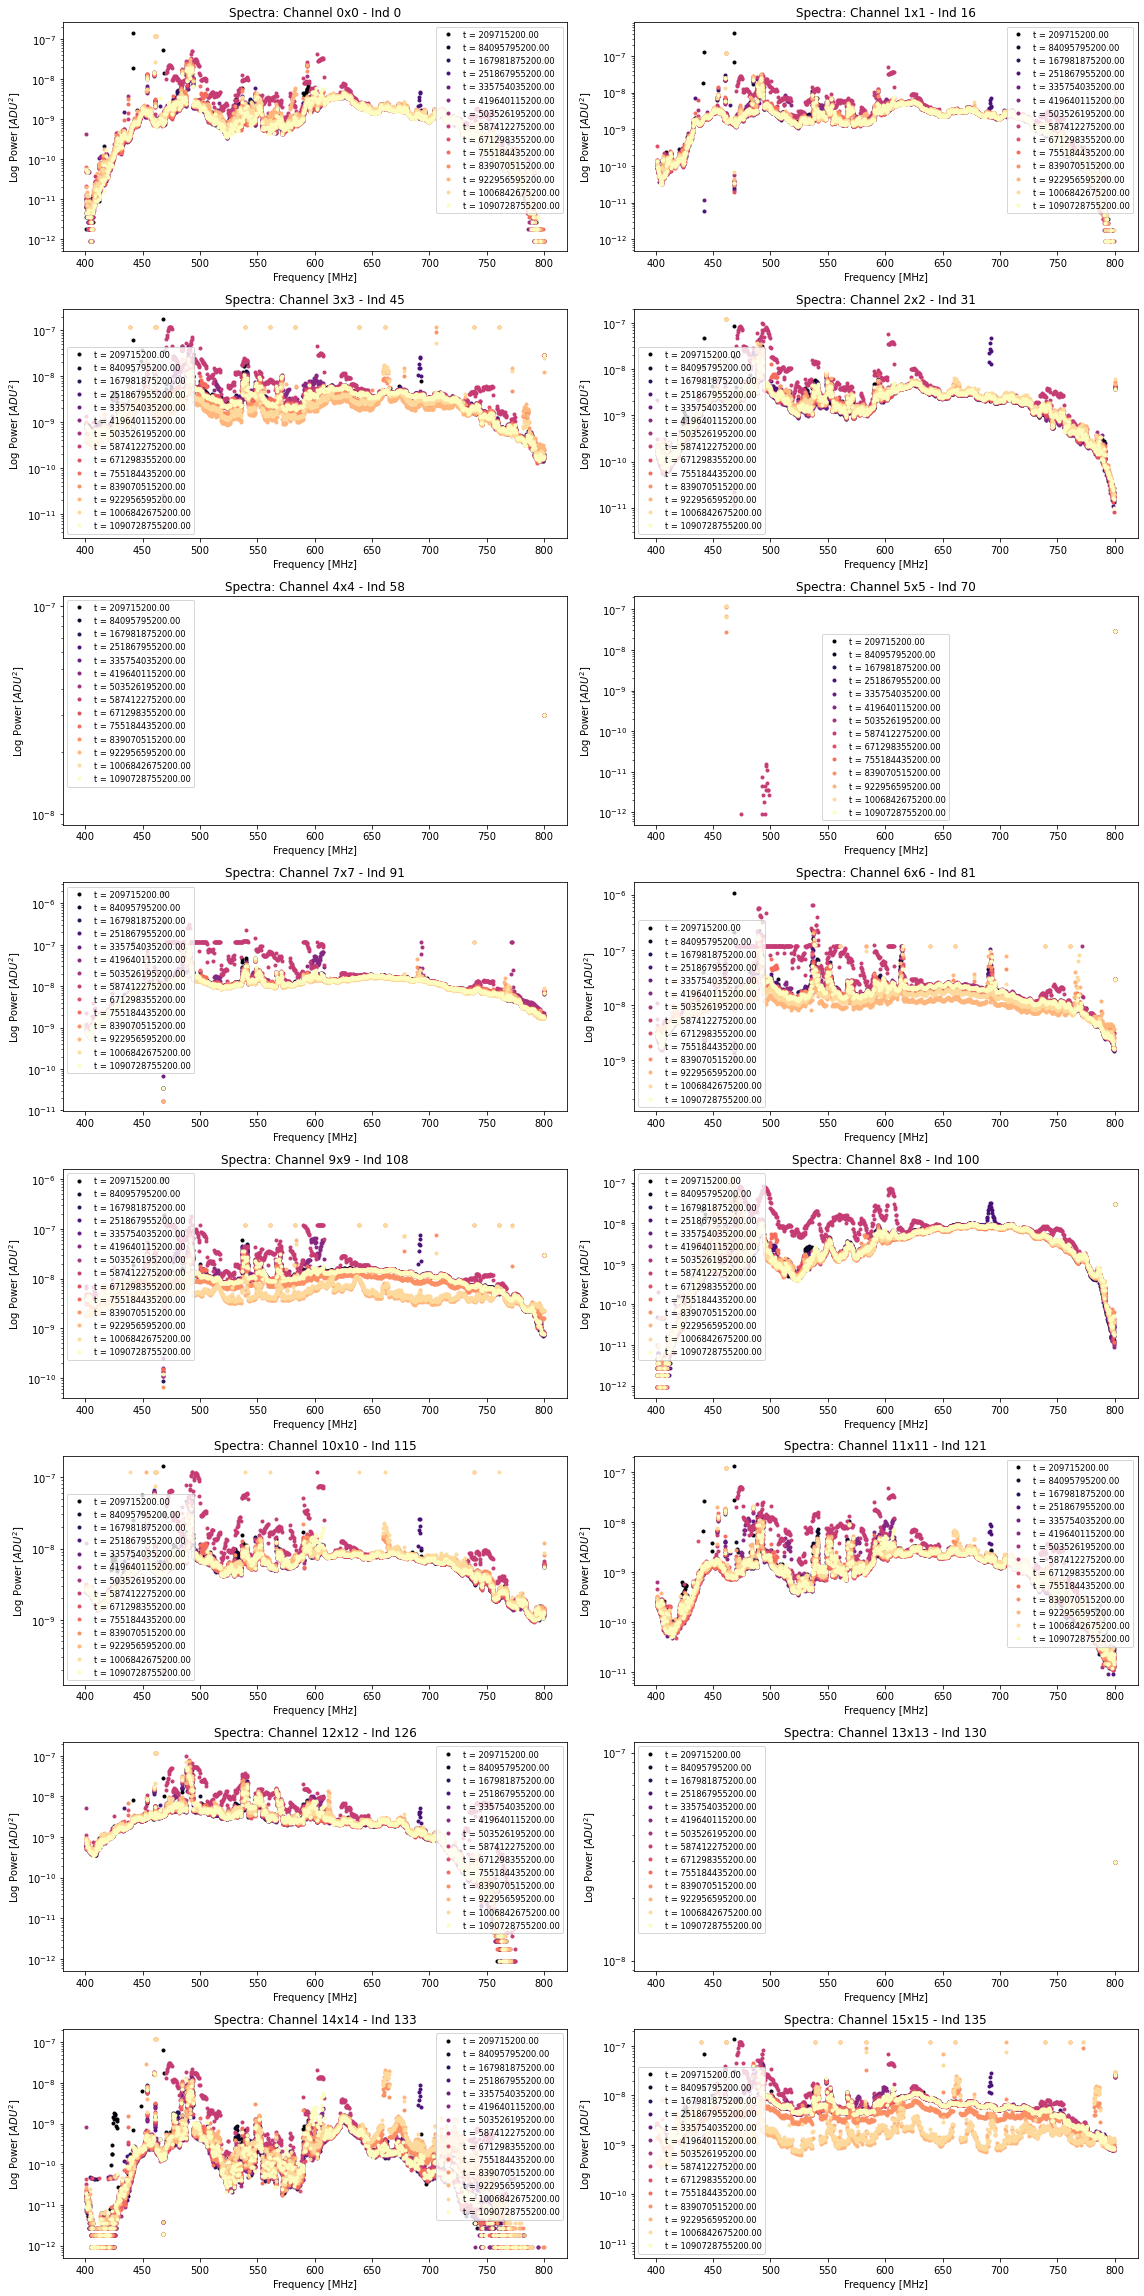

In [686]:
pu.Plot_Spectra(concattest)

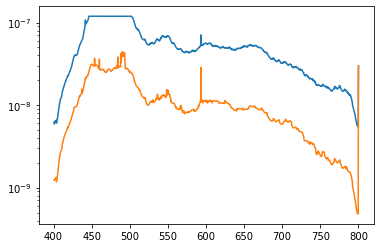

In [701]:
semilogy(concattest.freq,np.nanmax(concattest.V[14400:14600,:,0],axis=0))
semilogy(concattest.freq,np.nanmean(concattest.V[14400:14600,:,0],axis=0))
#semilogy(concattest.freq,np.nanmin(concattest.V[14400:14600,:,0],axis=0))